<h3><b>Data Exploration and Cleaning:</b></h3>

In [424]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.subplots import make_subplots
import re

In [425]:
df = pd.read_csv('laptopData.csv')
print(df.columns)
print(df.dtypes)

Index(['Unnamed: 0', 'Company', 'TypeName', 'Inches', 'ScreenResolution',
       'Cpu', 'Ram', 'Memory', 'Gpu', 'OpSys', 'Weight', 'Price'],
      dtype='object')
Unnamed: 0          float64
Company              object
TypeName             object
Inches               object
ScreenResolution     object
Cpu                  object
Ram                  object
Memory               object
Gpu                  object
OpSys                object
Weight               object
Price               float64
dtype: object


In [426]:
print(df.head())

   Unnamed: 0 Company   TypeName Inches                    ScreenResolution  \
0         0.0   Apple  Ultrabook   13.3  IPS Panel Retina Display 2560x1600   
1         1.0   Apple  Ultrabook   13.3                            1440x900   
2         2.0      HP   Notebook   15.6                   Full HD 1920x1080   
3         3.0   Apple  Ultrabook   15.4  IPS Panel Retina Display 2880x1800   
4         4.0   Apple  Ultrabook   13.3  IPS Panel Retina Display 2560x1600   

                          Cpu   Ram               Memory  \
0        Intel Core i5 2.3GHz   8GB            128GB SSD   
1        Intel Core i5 1.8GHz   8GB  128GB Flash Storage   
2  Intel Core i5 7200U 2.5GHz   8GB            256GB SSD   
3        Intel Core i7 2.7GHz  16GB            512GB SSD   
4        Intel Core i5 3.1GHz   8GB            256GB SSD   

                            Gpu  OpSys  Weight        Price  
0  Intel Iris Plus Graphics 640  macOS  1.37kg   71378.6832  
1        Intel HD Graphics 6000  macOS  

In [427]:
df.drop(columns='Unnamed: 0', inplace=True)
df.shape

(1303, 11)

In [428]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1273 non-null   object 
 1   TypeName          1273 non-null   object 
 2   Inches            1273 non-null   object 
 3   ScreenResolution  1273 non-null   object 
 4   Cpu               1273 non-null   object 
 5   Ram               1273 non-null   object 
 6   Memory            1273 non-null   object 
 7   Gpu               1273 non-null   object 
 8   OpSys             1273 non-null   object 
 9   Weight            1273 non-null   object 
 10  Price             1273 non-null   float64
dtypes: float64(1), object(10)
memory usage: 112.1+ KB


In [429]:
df.isnull().sum()

Company             30
TypeName            30
Inches              30
ScreenResolution    30
Cpu                 30
Ram                 30
Memory              30
Gpu                 30
OpSys               30
Weight              30
Price               30
dtype: int64

In [430]:
df.dropna(inplace=True)
df.shape

(1273, 11)

In [431]:
df.duplicated().sum()

np.int64(29)

The 29 null rows are shown as duplicated.

In [432]:
#for categorical data
#shows frequency and box plot with average price


def plot_cat_data(df, column):
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))

    # Sort categories by frequency for the histogram
    count_order = df[column].value_counts().index

    # Histogram (count plot)
    ax0 = sns.countplot(
        data=df,
        x=column,
        order=count_order,
        ax=axes[0],
        palette="viridis"
    )
    axes[0].set_title(f"Histogram for: {column}")
    axes[0].tick_params(axis='x', rotation=45, labelsize=10)

    # Add count labels on top of bars
    for p in ax0.patches:
        height = p.get_height()
        ax0.annotate(f'{int(height)}',
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom',
                     fontsize=9, color='black', xytext=(0, 3),
                     textcoords='offset points')

    # Sort by average price for the bar plot
    price_order = df.groupby(column)['Price'].mean().sort_values(ascending=False).index

    ax1 = sns.barplot(
        data=df,
        x=column,
        y='Price',
        order=price_order,
        ax=axes[1],
        palette="viridis"
    )
    axes[1].set_title(f"Average price for: {column}")
    axes[1].tick_params(axis='x', rotation=45, labelsize=10)

    # Add average price labels on top of bars
    for p in ax1.patches:
        height = p.get_height()
        ax1.annotate(f'{height:,.0f}',  # formatted with commas, no decimals
                     (p.get_x() + p.get_width() / 2., height),
                     ha='center', va='bottom',
                     fontsize=9, color='black', xytext=(0, 3),
                     textcoords='offset points')

    plt.tight_layout()
    plt.show()

In [433]:
#for numerical data
#smooth histogram(kde) and check for outliers

def plot_num_data(df, column):
    fig, axes = plt.subplots(2,1,figsize=(15,10))
    sns.kdeplot(x=df[column], ax=axes[0],fill=True,  color="blue" )
    axes[0].set_title(f"KDE plot for: {column}")
    sns.boxplot(x=df[column], ax=axes[1], color='skyblue')
    axes[1].set_title(f"Box plot  for: {column}")
    axes[1].tick_params(axis='x', rotation=90)
    plt.tight_layout()
    plt.show()
    
    
def count_outliers(df, column):
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        print(f"Number of outliers in {column}: {outliers.shape[0]}")
        return outliers

In [434]:
def plot_dist_cat(df, cat_features, target):
   
    fig, axes = plt.subplots(len(cat_features), 1, figsize=(15, len(cat_features) * 5))
    if  len(cat_features) == 1:
        axes = [axes]
    for i, column in enumerate(cat_features):
        order = df.groupby(column)[target].mean().sort_values(ascending=False).index
        sns.barplot(data=df, x=column, y=target, order=order, ax=axes[i], palette="Blues_d", saturation=0.8)
        axes[i].set_title(f'Bar Plot for {column} with Avg {target}')
        axes[i].tick_params(axis='x', rotation=90) 

    plt.tight_layout()

Now we start exploring the data.
<h4>Inches:</h4>

In [435]:
print(df['Inches'].value_counts())
df['Inches']= pd.to_numeric(df['Inches'], errors='coerce')
df['Inches']=df['Inches'].fillna(df['Inches'].mean())

Inches
15.6    640
14      192
17.3    162
13.3    161
12.5     38
11.6     31
12        6
13.9      6
13.5      5
12.3      5
15.4      4
15        4
10.1      3
35.6      3
13        2
24        2
18.4      1
27.3      1
25.6      1
33.5      1
?         1
17        1
31.6      1
14.1      1
11.3      1
Name: count, dtype: int64


In [436]:
df['Inches'].unique()

array([13.3       , 15.6       , 15.4       , 14.        , 12.        ,
       17.3       , 13.5       , 12.5       , 13.        , 18.4       ,
       13.9       , 11.6       , 25.6       , 35.6       , 12.3       ,
       27.3       , 24.        , 33.5       , 15.13081761, 31.6       ,
       17.        , 15.        , 14.1       , 11.3       , 10.1       ])

In [437]:
df['Inches'].dtype

dtype('float64')

Realistically more than 11-18 inches is not possible. Therefore those values must be in cm. We have to convert it to inches.

In [438]:
df.loc[df['Inches'] > 18, 'Inches'] = df['Inches'] / 2.54

In [439]:
df['Inches'] = df['Inches'].round(1)
df['Inches'].value_counts().sort_index()

Inches
7.2       1
9.4       2
10.1      4
10.7      1
11.3      1
11.6     31
12.0      6
12.3      5
12.4      1
12.5     38
13.0      2
13.2      1
13.3    161
13.5      5
13.9      6
14.0    195
14.1      1
15.0      4
15.1      1
15.4      4
15.6    640
17.0      1
17.3    162
Name: count, dtype: int64

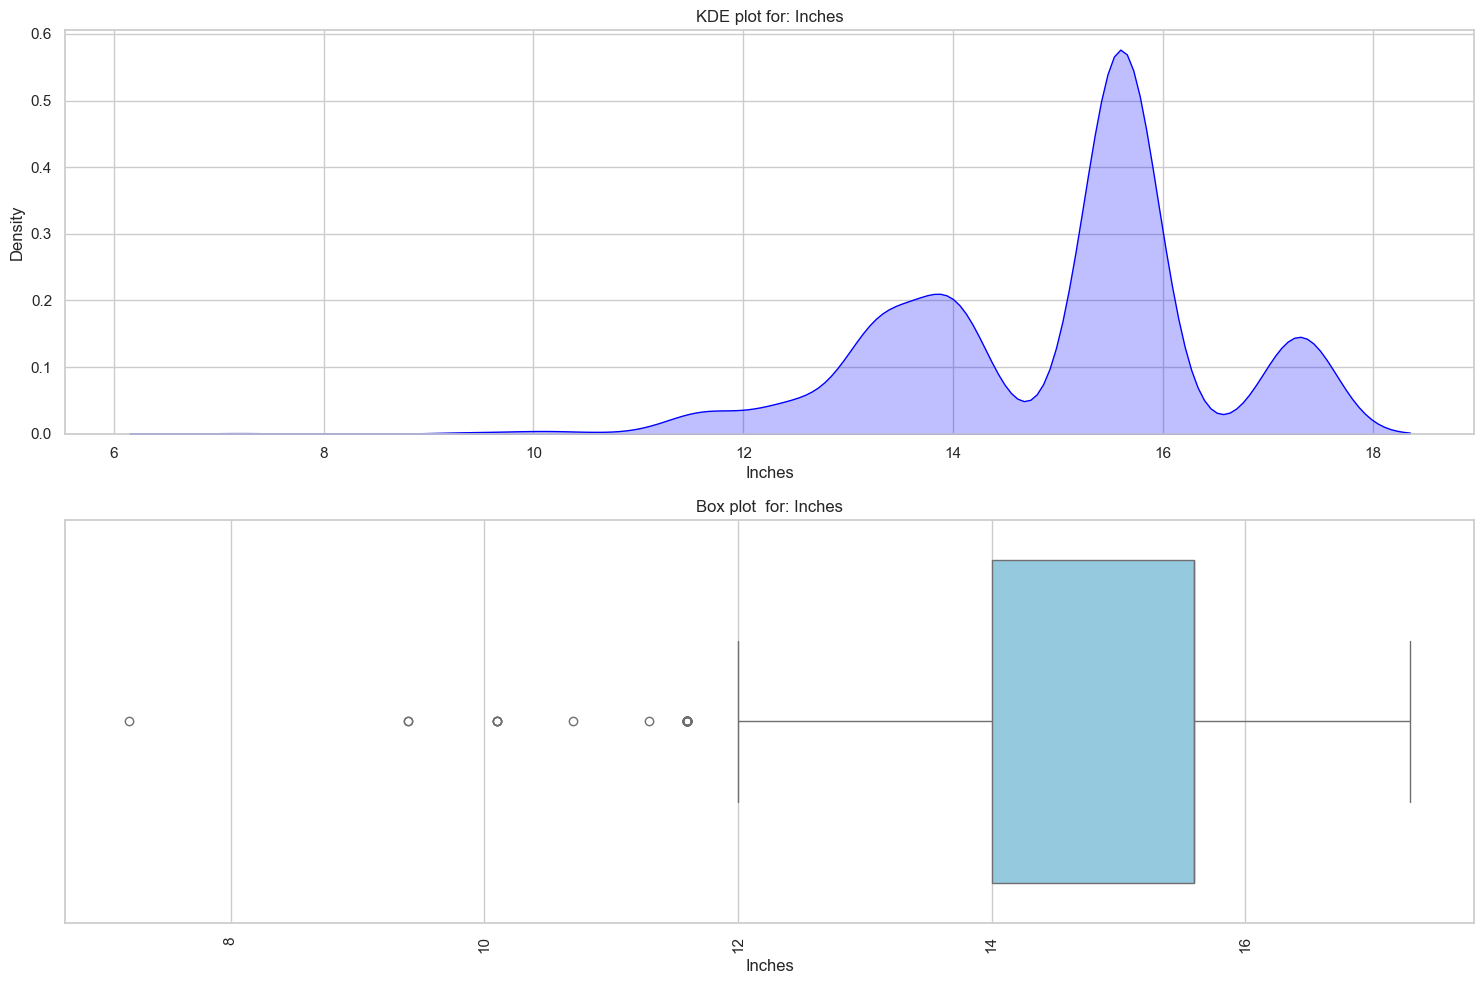

In [440]:
plot_num_data(df, 'Inches')

In [441]:
print(len(count_outliers(df, 'Inches')))

Number of outliers in Inches: 40
40


The KDE plot and the box plot shows a left skew with many outliers.

<h4>Weight:</h4>

In [442]:
print(df["Weight"].unique())

['1.37kg' '1.34kg' '1.86kg' '1.83kg' '2.1kg' '2.04kg' '1.3kg' '1.6kg'
 '2.2kg' '0.92kg' '1.22kg' '2.5kg' '1.62kg' '1.91kg' '2.3kg' '1.35kg'
 '1.88kg' '1.89kg' '1.65kg' '2.71kg' '1.2kg' '1.44kg' '2.8kg' '2kg'
 '2.65kg' '2.77kg' '3.2kg' '1.49kg' '2.4kg' '2.13kg' '2.43kg' '1.7kg'
 '1.4kg' '1.8kg' '1.9kg' '3kg' '1.252kg' '2.7kg' '2.02kg' '1.63kg'
 '1.96kg' '1.21kg' '2.45kg' '1.25kg' '1.5kg' '2.62kg' '1.38kg' '1.58kg'
 '1.85kg' '1.23kg' '2.16kg' '2.36kg' '7.2kg' '2.05kg' '1.32kg' '1.75kg'
 '0.97kg' '2.56kg' '1.48kg' '1.74kg' '1.1kg' '1.56kg' '2.03kg' '1.05kg'
 '5.4kg' '4.4kg' '1.90kg' '1.29kg' '2.0kg' '1.95kg' '2.06kg' '1.12kg'
 '3.49kg' '3.35kg' '2.23kg' '?' '2.9kg' '4.42kg' '2.69kg' '2.37kg' '4.7kg'
 '3.6kg' '2.08kg' '4.3kg' '1.68kg' '1.41kg' '4.14kg' '2.18kg' '2.24kg'
 '2.67kg' '4.1kg' '2.14kg' '1.36kg' '2.25kg' '2.15kg' '2.19kg' '2.54kg'
 '3.42kg' '5.8kg' '1.28kg' '2.33kg' '1.45kg' '2.79kg' '8.23kg' '1.26kg'
 '1.84kg' '0.0002kg' '2.6kg' '2.26kg' '3.25kg' '1.59kg' '1.13kg' '1.42kg'
 '1.7

In [443]:
df[df['Weight'] == '?']

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
208,Dell,Ultrabook,13.3,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,8GB,256GB SSD,Intel UHD Graphics 620,Windows 10,?,77202.72


Replacing the missing value with the proper weight of the laptop.

In [444]:
df['Weight'] = df['Weight'].replace('?', 1.22)

#Remove 'kg' and convert to float
df['Weight'] = df['Weight'].str.replace('kg', '', regex=False) \
                           .str.strip() \
                           .astype(float)

In [445]:
outliers_weight = count_outliers(df, 'Weight')
print(outliers_weight[['Company', 'TypeName', 'Weight', 'Inches', 'Price']])

Number of outliers in Weight: 55
      Company            TypeName   Weight  Inches        Price
133      Acer            Notebook   7.2000    15.6   30476.1600
173   Toshiba            Notebook   5.4000    15.6   26053.9200
177       MSI              Gaming   4.4000     7.2  149130.7200
224      Dell              Gaming   4.4200    17.3  130873.7952
238      Asus              Gaming   4.7000    17.3  207259.2000
240    Lenovo            Notebook   7.2000    15.6   31381.9200
247      Asus              Gaming   3.6000    17.3  159786.7200
251      Asus              Gaming   4.3000    17.3   95850.7200
258       MSI              Gaming   4.1400    17.3  133146.7200
266      Asus  2 in 1 Convertible   4.1000    13.3   79866.7200
302    Lenovo            Notebook   5.8000    17.3   34578.7200
326      Acer            Notebook   8.2300    15.6   29250.7200
349      Dell           Ultrabook   0.0002    15.6   35324.6400
424      Dell              Gaming   4.4200    10.7  149130.7200
456    

In [446]:
df = df[(df['Weight'] >= 1.0) & (df['Weight'] <= 5.0)]
df.reset_index(drop=True, inplace=True)
print(df['Weight'].describe())

count    1247.000000
mean        2.060281
std         0.663105
min         1.050000
25%         1.540000
50%         2.040000
75%         2.320000
max         4.700000
Name: Weight, dtype: float64


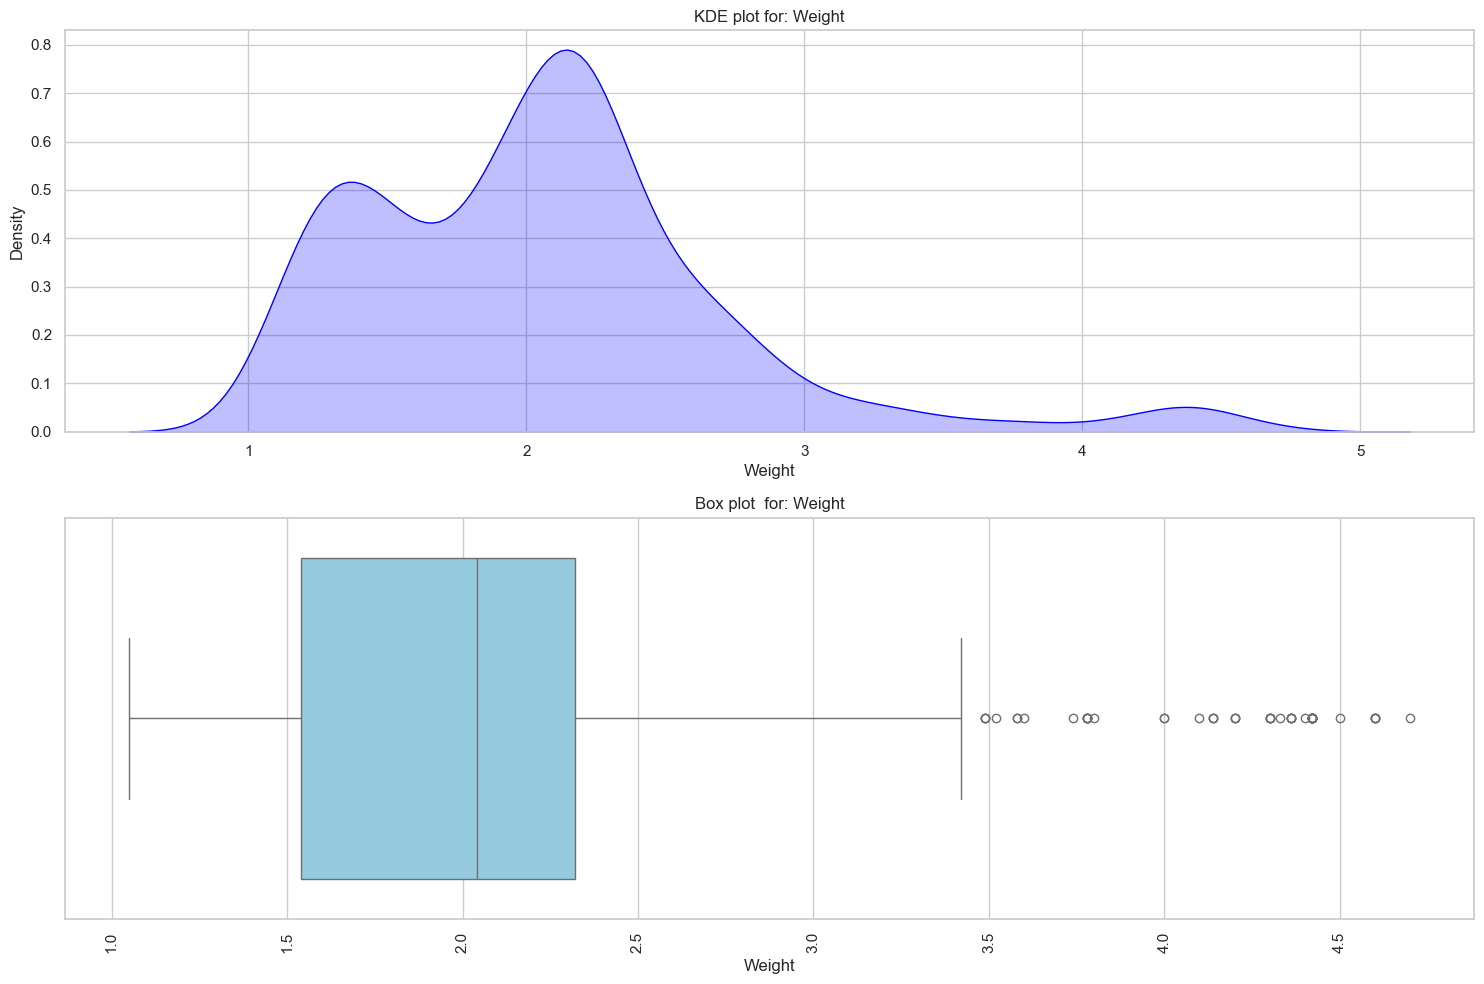

In [447]:
plot_num_data(df, 'Weight')

Weight column shows a bit of a right skew.

<h4>Screen Resolution:</h4>

In [448]:
df['ScreenResolution'].unique()

array(['IPS Panel Retina Display 2560x1600', '1440x900',
       'Full HD 1920x1080', 'IPS Panel Retina Display 2880x1800',
       '1366x768', 'IPS Panel Full HD 1920x1080',
       'IPS Panel Full HD / Touchscreen 1920x1080',
       'Full HD / Touchscreen 1920x1080',
       'Touchscreen / Quad HD+ 3200x1800', 'Touchscreen 2256x1504',
       'Quad HD+ / Touchscreen 3200x1800', 'IPS Panel 1366x768',
       'IPS Panel Full HD 2160x1440',
       'IPS Panel 4K Ultra HD / Touchscreen 3840x2160',
       '4K Ultra HD / Touchscreen 3840x2160', '1600x900',
       'IPS Panel 4K Ultra HD 3840x2160', '4K Ultra HD 3840x2160',
       'Touchscreen 1366x768', 'Touchscreen 2560x1440',
       'IPS Panel Full HD 1366x768', 'IPS Panel 2560x1440',
       'IPS Panel Full HD 2560x1440',
       'IPS Panel Retina Display 2736x1824', 'Touchscreen 2400x1600',
       '2560x1440', 'IPS Panel Quad HD+ 2560x1440',
       'IPS Panel Quad HD+ 3200x1800',
       'IPS Panel Quad HD+ / Touchscreen 3200x1800',
       'IPS P

In [449]:
# Extract width and height
df[['ResX', 'ResY']] = df['ScreenResolution'].str.extract(r'(\d+)x(\d+)').astype(float)

df['PPI'] = ((df['ResX']**2 + df['ResY']**2) ** 0.5) / df['Inches']

Next, we perform one-hot encoding for IPS panel, Touchscreen, Full HD, Quad HD/Quad HD+, Ultra HD/4K and Retina display.

In [450]:
df['IPS'] = df['ScreenResolution'].str.contains('IPS', case=False, na=False).astype(int)
df['Touchscreen'] = df['ScreenResolution'].str.contains('Touchscreen', case=False, na=False).astype(int)
df['FullHD'] = df['ScreenResolution'].str.contains('Full HD', case=False, na=False).astype(int)
df['QuadHD'] = df['ScreenResolution'].str.contains('Quad HD', case=False, na=False).astype(int)
df['UltraHD_4K'] = df['ScreenResolution'].str.contains('4K Ultra HD|3840x2160', case=False, na=False).astype(int)
df['Retina'] = df['ScreenResolution'].str.contains('Retina', case=False, na=False).astype(int)

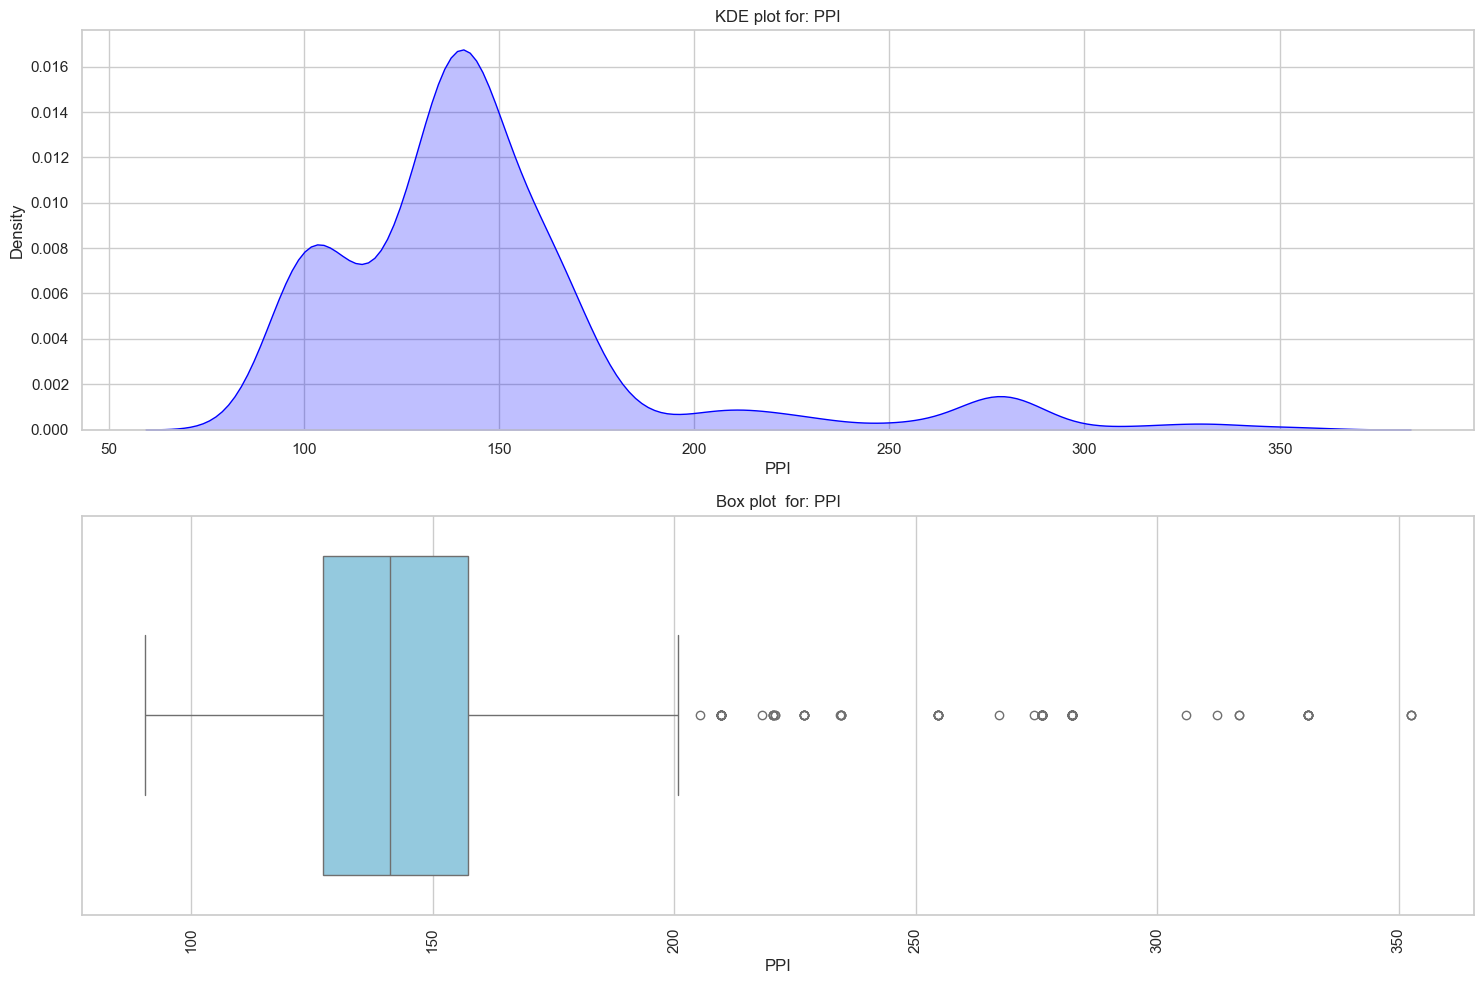

In [451]:
plot_num_data(df, 'PPI')

<h4>Ram:</h4>

In [452]:
df['Ram'].value_counts()

Ram
8GB     586
4GB     362
16GB    191
6GB      38
12GB     24
2GB      22
32GB     17
64GB      3
24GB      3
1GB       1
Name: count, dtype: int64

C:\Users\jahan\AppData\Local\Temp\ipykernel_13616\2116740628.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax0 = sns.countplot(
C:\Users\jahan\AppData\Local\Temp\ipykernel_13616\2116740628.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


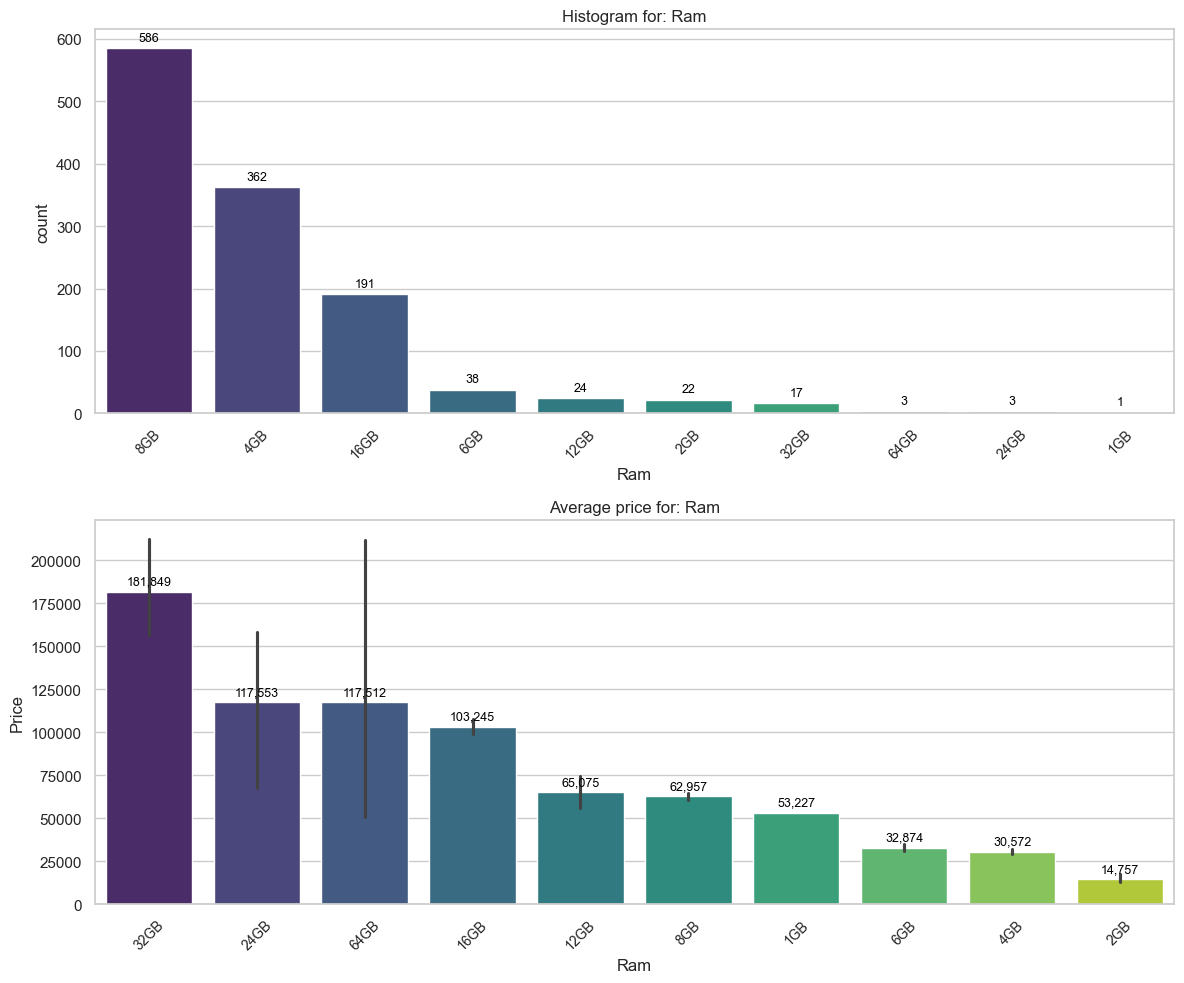

In [453]:
plot_cat_data(df, 'Ram')

The data is right skewed, we have to fix it for skewness later.

64GB Ram might be lower than 32GB Ram because the other specifications of 32GB devices might be better.

Secondly, we have to check the 1GB and 2GB ram rows to see whether those laptops actually exist.

In [454]:
df['Ram'] = df['Ram'].str.replace('GB', '', regex=False) \
                     .astype(int)
                     
print(df['Ram'].dtype)

int64


In [455]:
# Show all rows where RAM is 1GB/2GB
df[df['Ram'] == 1]

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,ResX,ResY,PPI,IPS,Touchscreen,FullHD,QuadHD,UltraHD_4K,Retina
674,Acer,2 in 1 Convertible,13.3,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i5 8250U 1.6GHz,1,256GB SSD,Intel UHD Graphics 620,Windows 10,1.6,53226.72,1920.0,1080.0,165.632118,1,1,1,0,0,0


In [456]:
df[df['Ram'] == 2]

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,ResX,ResY,PPI,IPS,Touchscreen,FullHD,QuadHD,UltraHD_4K,Retina
29,Asus,Notebook,14.0,1366x768,AMD E-Series E2-6110 1.5GHz,2,32GB Flash Storage,AMD Radeon R2,Windows 10,1.65,10602.720,1366.0,768.0,111.935204,0,0,0,0,0,0
86,Acer,Notebook,15.6,Full HD 1920x1080,Intel Core i7 8550U 1.8GHz,2,1TB HDD,Nvidia GeForce MX150,Windows 10,2.20,36709.920,1920.0,1080.0,141.211998,0,0,1,0,0,0
274,Acer,Notebook,15.6,1366x768,Intel Celeron Dual Core 3205U 1.5GHz,2,16GB SSD,Intel HD Graphics,Chrome OS,2.19,10602.720,1366.0,768.0,100.454670,0,0,0,0,0,0
297,Asus,2 in 1 Convertible,11.6,Touchscreen 1366x768,Intel Celeron Dual Core N3350 1.1GHz,2,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.10,14652.000,1366.0,768.0,135.094211,0,1,0,0,0,0
327,HP,Notebook,14.0,1366x768,Intel Celeron Dual Core N3060 1.6GHz,2,32GB Flash Storage,Intel HD Graphics 400,Windows 10,1.44,14865.120,1366.0,768.0,111.935204,0,0,0,0,0,0
388,Lenovo,Notebook,11.6,1366x768,Intel Celeron Dual Core N3350 1.1GHz,2,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.15,16221.096,1366.0,768.0,135.094211,0,0,0,0,0,0
492,Asus,Netbook,11.6,1366x768,Intel Celeron Dual Core N3350 1.1GHz,2,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.10,13053.600,1366.0,768.0,135.094211,0,0,0,0,0,0
599,Mediacom,Notebook,14.0,Full HD 1920x1080,Intel Atom x5-Z8350 1.44GHz,2,32GB Flash Storage,Intel HD Graphics,Windows 10,1.40,12733.920,1920.0,1080.0,157.350512,0,0,1,0,0,0
608,Lenovo,Notebook,14.0,1366x768,Intel Celeron Dual Core N3060 1.6GHz,2,32GB Flash Storage,Intel HD Graphics 400,Windows 10,1.42,13266.720,1366.0,768.0,111.935204,0,0,0,0,0,0
712,Acer,Notebook,14.0,1366x768,Intel Celeron Dual Core N3060 1.6GHz,2,32GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.68,17582.400,1366.0,768.0,111.935204,0,0,0,0,0,0


Unlike the 1 GB Acer convertible we saw earlier (which was clearly a mismatch), these 2 GB entries are internally consistent — CPU, storage, resolution, and price all match expectations for low-RAM devices.
So we will only replace the value of 1GB Acer laptop

In [457]:
df.loc[674, 'Ram'] = 8
df['Ram'].unique()

array([ 8, 16,  4,  2, 12, 64,  6, 32, 24])

<h4>Company:</h4>

C:\Users\jahan\AppData\Local\Temp\ipykernel_13616\2116740628.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax0 = sns.countplot(
C:\Users\jahan\AppData\Local\Temp\ipykernel_13616\2116740628.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


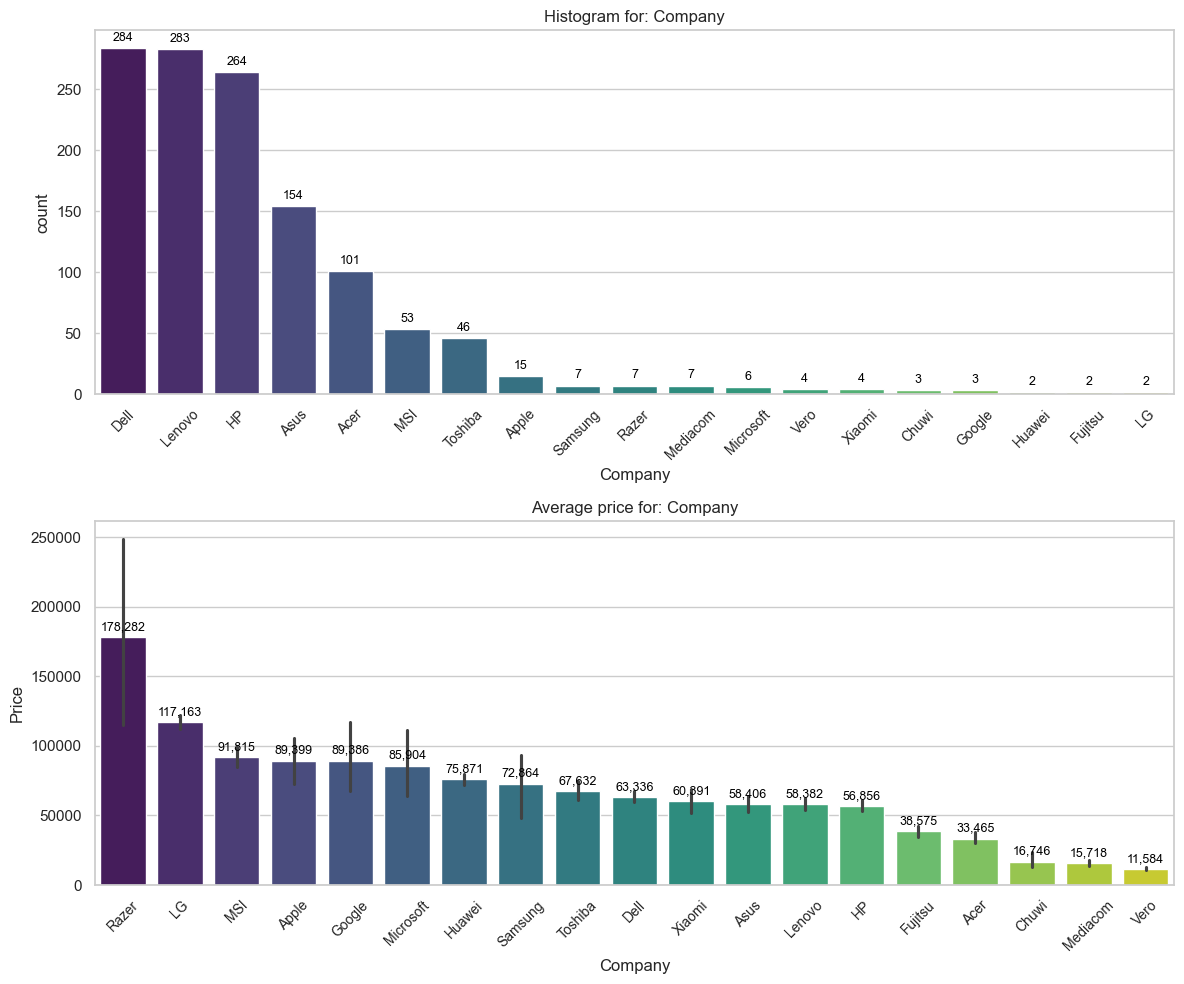

In [458]:
plot_cat_data(df, 'Company')

Since Vero is a subgroup of Acer, that rows will be merged to the 'Acer' rows.

The companies with less than 5 data entries will be categorized into a 'Other' group

In [459]:
# Merge sub-brands
df['Company'] = df['Company'].replace({'Vero': 'Acer'})

# Group companies with < 5 entries into 'Other'
company_counts = df['Company'].value_counts()
rare_companies = company_counts[company_counts < 5].index
df['Company'] = df['Company'].replace(rare_companies, 'Other')

print(df['Company'].value_counts())

Company
Dell         284
Lenovo       283
HP           264
Asus         154
Acer         105
MSI           53
Toshiba       46
Other         16
Apple         15
Mediacom       7
Razer          7
Samsung        7
Microsoft      6
Name: count, dtype: int64


In [460]:
# One-hot encoding

df = pd.get_dummies(df, columns=['Company'], prefix='Brand')

<h4>TypeName:</h4>

In [461]:
print(df['TypeName'].value_counts())

TypeName
Notebook              704
Gaming                203
Ultrabook             175
2 in 1 Convertible    113
Workstation            29
Netbook                23
Name: count, dtype: int64


C:\Users\jahan\AppData\Local\Temp\ipykernel_13616\2116740628.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax0 = sns.countplot(
C:\Users\jahan\AppData\Local\Temp\ipykernel_13616\2116740628.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


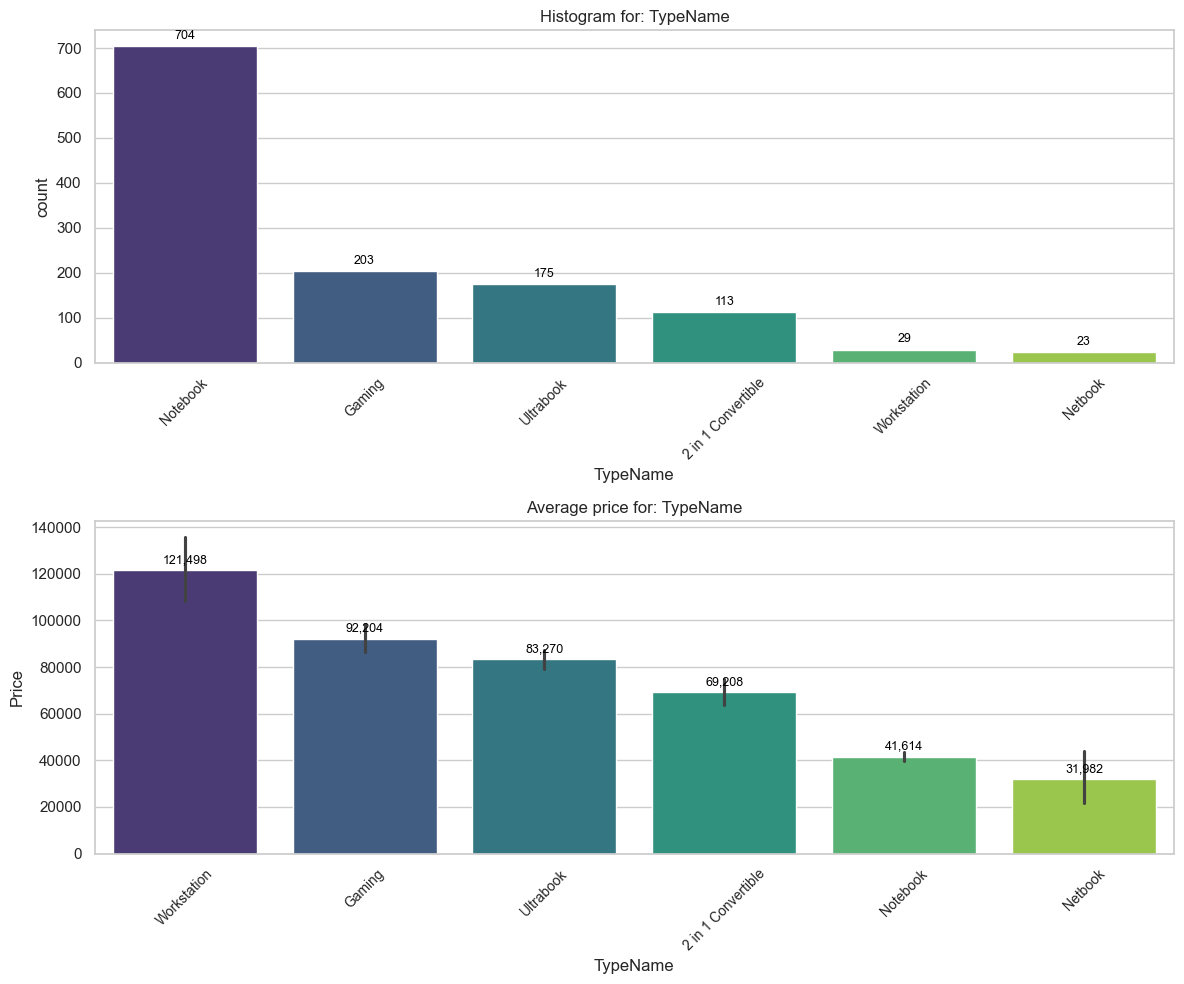

In [462]:
plot_cat_data(df, 'TypeName')

In [463]:
#for simplicty

df['TypeName'] = df['TypeName'].replace({'2 in 1 Convertible': 'Convertible'})

In [464]:
# Show all Netbook entries
df[df['TypeName'] == 'Netbook']

,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,...,Brand_Dell,Brand_HP,Brand_Lenovo,Brand_MSI,Brand_Mediacom,Brand_Microsoft,Brand_Other,Brand_Razer,Brand_Samsung,Brand_Toshiba
355,Netbook,11.6,IPS Panel 1366x768,Intel Celeron Quad Core N3450 1.1GHz,4,128GB SSD,Intel HD Graphics 500,Windows 10,1.59,29463.840,...,False,False,True,False,False,False,False,False,False,False
409,Netbook,11.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4,16GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.15,14332.320,...,False,False,False,False,False,False,False,False,True,False
440,Netbook,11.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4,128GB SSD,Intel HD Graphics 400,Windows 10,1.40,23176.800,...,False,False,False,False,False,False,False,False,False,False
477,Netbook,11.6,1366x768,Intel Celeron Dual Core N3350 1.1GHz,4,64GB Flash Storage,Intel HD Graphics 500,Windows 10 S,1.20,18115.200,...,False,False,False,False,False,False,False,False,False,False
481,Netbook,11.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4,16GB SSD,Intel HD Graphics 400,Chrome OS,1.25,14119.200,...,False,False,True,False,False,False,False,False,False,False
492,Netbook,11.6,1366x768,Intel Celeron Dual Core N3350 1.1GHz,2,32GB Flash Storage,Intel HD Graphics 500,Windows 10,1.10,13053.600,...,False,False,False,False,False,False,False,False,False,False
560,Netbook,11.6,1366x768,Intel Celeron Dual Core N3060 1.6GHz,4,16GB Flash Storage,Intel HD Graphics 400,Chrome OS,1.26,15717.600,...,True,False,False,False,False,False,False,False,False,False
664,Netbook,11.6,1366x768,Intel Celeron Dual Core N3050 1.6GHz,4,32GB Flash Storage,Intel HD Graphics,Windows 10,1.40,14332.320,...,False,False,False,False,False,False,False,False,False,False
715,Netbook,11.6,Touchscreen 1366x768,Intel Celeron Dual Core N3060 1.6GHz,4,128GB SSD,Intel HD Graphics 400,Windows 10,1.40,25308.000,...,False,False,True,False,False,False,False,False,False,False
766,Netbook,11.6,1366x768,Intel Pentium Quad Core N4200 1.1GHz,4,128GB SSD,Intel HD Graphics 505,Windows 10,1.63,39640.320,...,True,False,False,False,False,False,False,False,False,False


Thus we check that netbook is not a type. The data entries are valid Netbook entries. They represent a distinct segment of the market — ultra-portable, low-cost laptops

In [465]:
df = pd.get_dummies(df, columns=['TypeName'], prefix='Type')

<h4>Memory:</h4>

In [466]:
df['Memory'].unique()

array(['128GB SSD', '128GB Flash Storage', '256GB SSD', '512GB SSD',
       '500GB HDD', '256GB Flash Storage', '1TB HDD',
       '128GB SSD +  1TB HDD', '256GB SSD +  256GB SSD',
       '64GB Flash Storage', '32GB Flash Storage', '256GB SSD +  1TB HDD',
       '256GB SSD +  2TB HDD', '32GB SSD', '2TB HDD', '64GB SSD',
       '1.0TB Hybrid', '512GB SSD +  1TB HDD', '1TB SSD',
       '256GB SSD +  500GB HDD', '128GB SSD +  2TB HDD',
       '512GB SSD +  512GB SSD', '16GB SSD', '16GB Flash Storage',
       '512GB SSD +  256GB SSD', '512GB SSD +  2TB HDD',
       '64GB Flash Storage +  1TB HDD', '180GB SSD', '1TB HDD +  1TB HDD',
       '32GB HDD', '1TB SSD +  1TB HDD', '?', '128GB HDD', '240GB SSD',
       '8GB SSD', '508GB Hybrid', '1.0TB HDD',
       '512GB SSD +  1.0TB Hybrid', '256GB SSD +  1.0TB Hybrid'],
      dtype=object)

In [467]:

def clean_memory_features(df, col='Memory'):
    
    df[col] = df[col].replace('?', np.nan)

    #strip spacing and "Flash Storage"
    series = df[col].fillna('').astype(str).str.strip()
    series = (series
              .str.replace(r'\s*\+\s*', ' + ', regex=True)  # normalize spaces around '+'
              .str.replace(r'Flash\s*Storage', 'Flash', regex=True)  # unify Flash naming
             )


    pattern = re.compile(
        r'(?P<size>\d*\.?\d+)\s*(?P<unit>TB|GB)\s*(?P<type>SSD|HDD|Hybrid|Flash)',
        flags=re.IGNORECASE
    )

    hdd, ssd, flash, hybrid = [], [], [], []

    for s in series:
        total_hdd = total_ssd = total_flash = total_hybrid = 0.0

        for m in pattern.finditer(s):
            size = float(m.group('size'))  # numeric capacity
            unit = m.group('unit').upper() # GB or TB
            dtype = m.group('type').lower() # storage type

            gb = size * (1024.0 if unit == 'TB' else 1.0)

            if dtype == 'hdd':
                total_hdd += gb
            elif dtype == 'ssd':
                total_ssd += gb
            elif dtype == 'flash':
                total_flash += gb
            elif dtype == 'hybrid':
                total_hybrid += gb

        
        hdd.append(total_hdd)
        ssd.append(total_ssd)
        flash.append(total_flash)
        hybrid.append(total_hybrid)

    df['HDD'] = np.round(hdd).astype(int)
    df['SSD'] = np.round(ssd).astype(int)
    df['Flash'] = np.round(flash).astype(int)
    df['Hybrid'] = np.round(hybrid).astype(int)

    return df

In [468]:
df = clean_memory_features(df, col='Memory')

In [469]:
df[['Memory','HDD','SSD','Flash','Hybrid']].head()

,Memory,HDD,SSD,Flash,Hybrid
0,128GB SSD,0,128,0,0
1,128GB Flash Storage,0,0,128,0
2,256GB SSD,0,256,0,0
3,512GB SSD,0,512,0,0
4,256GB SSD,0,256,0,0


In [470]:
# Check if any NaN exists in these columns
df[['HDD','SSD','Flash','Hybrid']].isna().sum()

HDD       0
SSD       0
Flash     0
Hybrid    0
dtype: int64

In [471]:
# Find rows where all storage types are zero
zero_rows = df[(df[['HDD','SSD','Flash','Hybrid']].sum(axis=1) == 0)]

print(f"Number of all-zero rows: {len(zero_rows)}")
display(zero_rows)

Number of all-zero rows: 1


,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,ResX,...,Type_Convertible,Type_Gaming,Type_Netbook,Type_Notebook,Type_Ultrabook,Type_Workstation,HDD,SSD,Flash,Hybrid
734,15.6,Full HD 1920x1080,Intel Core i7 7500U 2.7GHz,16,NaN,AMD Radeon R7 M445,Windows 10,2.3,62938.0656,1920.0,...,False,False,False,True,False,False,0,0,0,0


Since there is just one data, we will look up its actual storage values and input them.

In [472]:
df.loc[734, 'Memory'] = '128GB SSD + 1TB HDD'
df.loc[734, 'SSD'] = 128
df.loc[734, 'HDD'] = 1024

<h4>GPU:</h4>

In [473]:
df['Gpu'].unique()

array(['Intel Iris Plus Graphics 640', 'Intel HD Graphics 6000',
       'Intel HD Graphics 620', 'AMD Radeon Pro 455',
       'Intel Iris Plus Graphics 650', 'AMD Radeon R5',
       'Intel Iris Pro Graphics', 'Nvidia GeForce MX150',
       'Intel UHD Graphics 620', 'Intel HD Graphics 520',
       'AMD Radeon Pro 555', 'AMD Radeon R5 M430', 'AMD Radeon Pro 560',
       'Nvidia GeForce 940MX', 'Nvidia GeForce GTX 1050', 'AMD Radeon R2',
       'AMD Radeon 530', 'Nvidia GeForce 930MX', 'Intel HD Graphics',
       'Intel HD Graphics 500', 'Nvidia GeForce 930MX ',
       'Nvidia GeForce GTX 1060', 'Nvidia GeForce 150MX',
       'Intel Iris Graphics 540', 'AMD Radeon RX 580',
       'Nvidia GeForce 920MX', 'AMD Radeon R4 Graphics', 'AMD Radeon 520',
       'Nvidia GeForce GTX 1070', 'Nvidia GeForce GTX 1050 Ti',
       'Intel HD Graphics 400', 'Nvidia GeForce MX130', 'AMD R4 Graphics',
       'Nvidia GeForce GTX 940MX', 'AMD Radeon RX 560',
       'Nvidia GeForce 920M', 'AMD Radeon R7 M445',

In [474]:
df['Gpu'] = df['Gpu'].str.strip()
df['GpuBrand'] = df['Gpu'].str.split().str[0]

# Dedicated GPU flag: 1 if Nvidia or AMD, else 0
df['DedicatedGPU'] = df['GpuBrand'].apply(lambda x: 1 if x in ['Nvidia', 'AMD'] else 0)

# Average price by GPU brand
avg_price_by_brand = df.groupby('GpuBrand')['Price'].mean().sort_values(ascending=False)
print(avg_price_by_brand)

# Average price by DedicatedGPU flag
avg_price_by_dedicated = df.groupby('DedicatedGPU')['Price'].mean()
print("\nAverage price by DedicatedGPU:")
print(avg_price_by_dedicated)

GpuBrand
Nvidia    79487.938717
Intel     53358.888042
AMD       41455.079669
ARM       35111.520000
Name: Price, dtype: float64

Average price by DedicatedGPU:
DedicatedGPU
0    53332.132371
1    67775.164426
Name: Price, dtype: float64


In [475]:
df = pd.get_dummies(df, columns=['GpuBrand'], prefix='GPU')

<h4>CPU</h4>

In [476]:
df['Cpu'].unique()

array(['Intel Core i5 2.3GHz', 'Intel Core i5 1.8GHz',
       'Intel Core i5 7200U 2.5GHz', 'Intel Core i7 2.7GHz',
       'Intel Core i5 3.1GHz', 'AMD A9-Series 9420 3GHz',
       'Intel Core i7 2.2GHz', 'Intel Core i7 8550U 1.8GHz',
       'Intel Core i5 8250U 1.6GHz', 'Intel Core i3 6006U 2GHz',
       'Intel Core i7 2.8GHz', 'Intel Core i7 7500U 2.7GHz',
       'Intel Core i7 2.9GHz', 'Intel Core i3 7100U 2.4GHz',
       'Intel Core i5 7300HQ 2.5GHz', 'AMD E-Series E2-9000e 1.5GHz',
       'Intel Core i5 1.6GHz', 'Intel Core i7 8650U 1.9GHz',
       'Intel Atom x5-Z8300 1.44GHz', 'AMD E-Series E2-6110 1.5GHz',
       'AMD A6-Series 9220 2.5GHz',
       'Intel Celeron Dual Core N3350 1.1GHz',
       'Intel Core i3 7130U 2.7GHz', 'Intel Core i7 7700HQ 2.8GHz',
       'Intel Core i5 2.0GHz', 'AMD Ryzen 1700 3GHz',
       'Intel Pentium Quad Core N4200 1.1GHz',
       'Intel Celeron Dual Core N3060 1.6GHz', 'AMD FX 9830P 3GHz',
       'Intel Core i7 7560U 2.4GHz', 'AMD E-Series 6110 1.

In [477]:
def process_cpu(df):
    df['Cpu'] = df['Cpu'].str.strip()

    df['CpuBrand'] = df['Cpu'].str.split().str[0]

    df['CpuBrand'] = df['CpuBrand'].replace({'Samsung': 'AMD'})

    df['CpuClock'] = df['Cpu'].str.extract(r'(\d+\.\d+)GHz').astype(float)

    def cpu_tier(cpu):
        cpu_lower = cpu.lower()
        if any(x in cpu_lower for x in ['i7', 'i9', 'ryzen 7', 'ryzen 9']):
            return 'High'
        elif any(x in cpu_lower for x in ['i5', 'ryzen 5']):
            return 'Mid'
        else:
            return 'Low'

    df['CpuTier'] = df['Cpu'].apply(cpu_tier)

    return df

In [478]:
df = process_cpu(df)

In [479]:
# One-hot encode cpu brand and tier

df = pd.get_dummies(df, columns=['CpuBrand'], prefix='CPU')

df = pd.get_dummies(df, columns=['CpuTier'], prefix='Tier')

<h4>Operating System:</h4>

In [480]:
df['OpSys'].unique()

array(['macOS', 'No OS', 'Windows 10', 'Mac OS X', 'Linux',
       'Windows 10 S', 'Chrome OS', 'Windows 7'], dtype=object)

C:\Users\jahan\AppData\Local\Temp\ipykernel_13616\2116740628.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax0 = sns.countplot(
C:\Users\jahan\AppData\Local\Temp\ipykernel_13616\2116740628.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax1 = sns.barplot(


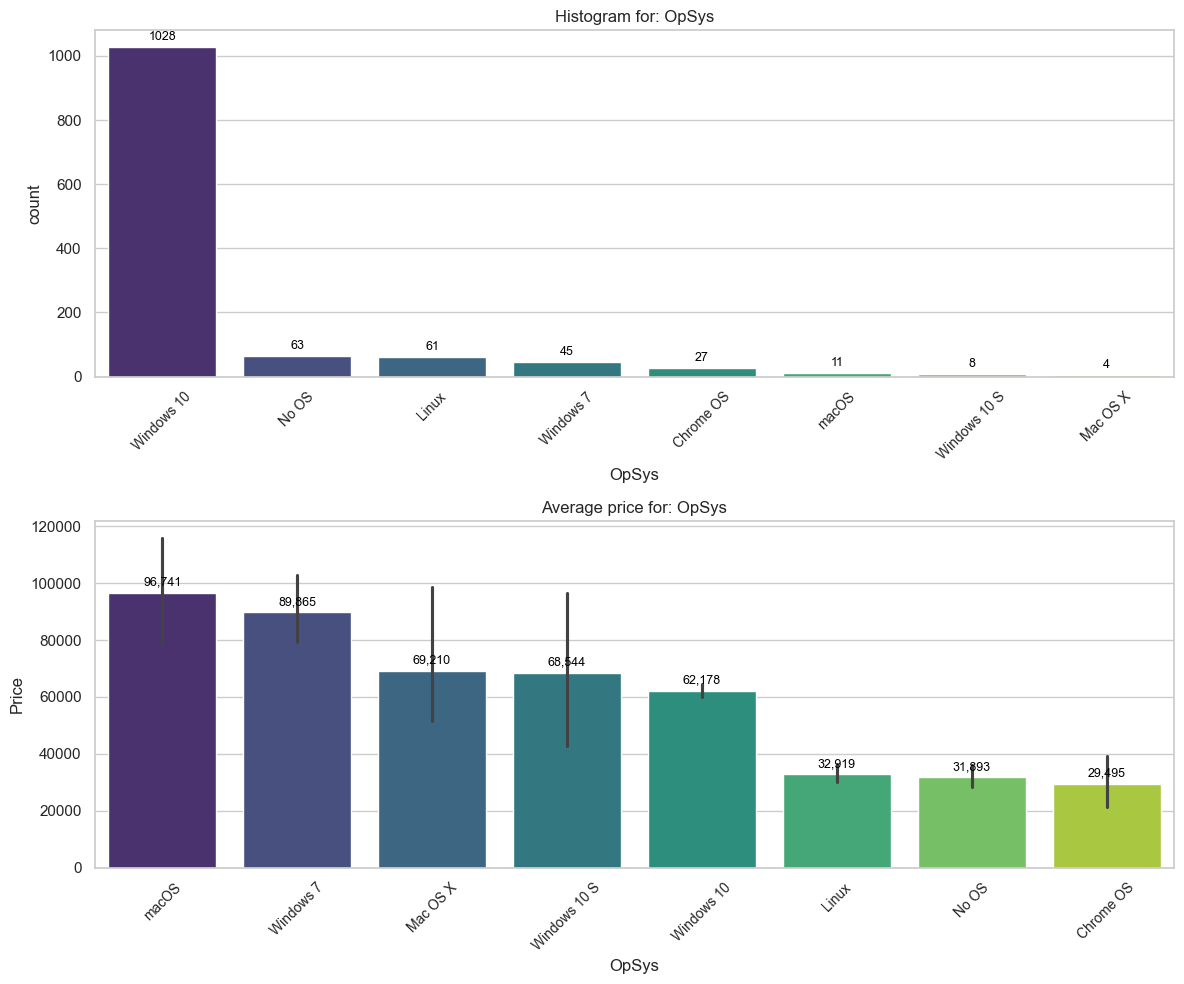

In [481]:
plot_cat_data(df, 'OpSys')

In [482]:
def process_opsys(df):
    # --- OpSys Cleaning ---
    df['OpSys'] = df['OpSys'].replace({
        'Mac OS X': 'MacOS',
        'macOS': 'MacOS',
        'Windows 10 S': 'Windows 10',
        'Windows 7': 'Windows 10',   # merge into Windows 10
        'Linux': 'Other OS',
        'Chrome OS': 'Other OS',
        'No OS': 'Other OS'
    })

    # Rename Windows 10 to just 'Windows'
    df['OpSys'] = df['OpSys'].replace({'Windows 10': 'Windows'})

    return df


In [483]:
df = process_opsys(df)
df = pd.get_dummies(df, columns=['OpSys'], prefix='OS')